# Replicating Lee & Wooldridge (2026) Section 7.2: Castle Law Analysis

This notebook replicates the Castle Law analysis from **Section 7.2** of:

> Lee, S. J., and Wooldridge, J. M. (2026). "Simple Approaches to Inference with Difference-in-Differences Estimators with Small Cross-Sectional Sample Sizes." *Available at SSRN 5325686*.

## Paper Context (Section 7.2)

The paper analyzes the effects of **Castle Laws** ("Stand Your Ground" laws) on homicide rates in the United States, using staggered DiD methods.

### Key Results from the Paper:

| Method | ATT (τ̂_ω) | SE (OLS) | SE (HC3) | t-statistic |
|--------|-----------|---------|---------|-------------|
| **Demeaning** | 0.092 | 0.057 | - | 1.61 (OLS), 1.50 (HC3) |
| **Detrending** | 0.067 | - | 0.055 | 1.21 |
| **SDiD** | 0.099 | 0.069 | - | 1.41 |

### Data Description (from the paper):

> "The data set covers the 50 United States from 2000 through 2010. In 2005, one state adopted a castle law. In 2006, 13 more states did. The remaining treated cohorts are 2007 (four states), 2008 (two states), and 2009 (one state). Therefore, there are N_treat = 21 eventually treated units and N_control = 29 control units. The outcome variable is the log of the annual homicides."

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from lwdid import lwdid

print("lwdid package loaded successfully")

lwdid package loaded successfully


## 1. Data Loading and Verification

First, we load the Castle Law data and verify it matches the paper's description.

In [12]:
# Load data (data file is in ../data/ directory)
import os
data_path = os.path.join(os.path.dirname(os.path.abspath('.')), 'data', 'castle.csv')
# Alternative: use relative path from examples folder
data = pd.read_csv('../data/castle.csv')

# Create gvar (first treatment year)
# effyear: year when state enacted Castle Doctrine
# NaN means never treated -> convert to 0
data['gvar'] = data['effyear'].fillna(0).astype(int)

# Verify data structure matches paper
print("=" * 60)
print("DATA VERIFICATION (Paper Section 7.2)")
print("=" * 60)
print(f"\nYears covered: {data['year'].min()} - {data['year'].max()}")
print(f"States: {data['sid'].nunique()}")
print(f"Total observations: {len(data)}")

DATA VERIFICATION (Paper Section 7.2)

Years covered: 2000 - 2010
States: 50
Total observations: 550


In [13]:
# Verify cohort structure matches paper exactly
cohort_sizes = data.drop_duplicates('sid').groupby('gvar')['sid'].count()

print("\nCohort Structure (comparing with paper):")
print("-" * 50)

# Paper states:
# "In 2005, one state adopted a castle law."
# "In 2006, 13 more states did."
# "2007 (four states), 2008 (two states), and 2009 (one state)"
paper_cohorts = {2005: 1, 2006: 13, 2007: 4, 2008: 2, 2009: 1}

print(f"{'Cohort':<10} {'Paper':<10} {'Data':<10} {'Match':<10}")
print("-" * 50)
for g in [2005, 2006, 2007, 2008, 2009]:
    paper_n = paper_cohorts[g]
    data_n = cohort_sizes.get(g, 0)
    match = "✓" if paper_n == data_n else "✗"
    print(f"{g:<10} {paper_n:<10} {data_n:<10} {match:<10}")

# Never treated
n_never = cohort_sizes.get(0, 0)
n_treated = sum(cohort_sizes[cohort_sizes.index > 0])
print("-" * 50)
print(f"N_treat (paper: 21):   {n_treated}  {'✓' if n_treated == 21 else '✗'}")
print(f"N_control (paper: 29): {n_never}  {'✓' if n_never == 29 else '✗'}")


Cohort Structure (comparing with paper):
--------------------------------------------------
Cohort     Paper      Data       Match     
--------------------------------------------------
2005       1          1          ✓         
2006       13         13         ✓         
2007       4          4          ✓         
2008       2          2          ✓         
2009       1          1          ✓         
--------------------------------------------------
N_treat (paper: 21):   21  ✓
N_control (paper: 29): 29  ✓


## 2. Replicating Paper Results: Overall Effect with Demeaning

From the paper:
> "Using the regression in (7.19) with $\bar{\dot{Y}}_i$ defined in (7.18), the estimated aggregated treatment effect, $\hat{\tau}_\omega$, is about **0.092**, or about 9.2% more homicides from a state adopting a castle law. The usual OLS standard error is **0.057**, which gives t ≈ **1.61**. This is not quite significant at the 10% level against a two-sided alternative. The hc3 t statistic is **1.50**."

In [14]:
# Replicate demeaning result with OLS SE
results_demean_ols = lwdid(
    data=data,
    y='lhomicide',
    ivar='sid',
    tvar='year',
    gvar='gvar',
    rolling='demean',
    control_group='never_treated',
    aggregate='overall',
    vce=None  # OLS standard errors
)

# Replicate demeaning result with HC3 SE
results_demean_hc3 = lwdid(
    data=data,
    y='lhomicide',
    ivar='sid',
    tvar='year',
    gvar='gvar',
    rolling='demean',
    control_group='never_treated',
    aggregate='overall',
    vce='hc3'  # HC3 standard errors
)

print("=" * 70)
print("DEMEANING RESULTS COMPARISON")
print("=" * 70)
print(f"\n{'Statistic':<25} {'Paper':<15} {'Python':<15} {'Diff':<15}")
print("-" * 70)

# ATT
paper_att = 0.092
python_att = results_demean_ols.att_overall
print(f"{'ATT (τ̂_ω)':<25} {paper_att:<15.4f} {python_att:<15.4f} {abs(python_att - paper_att):<15.6f}")

# OLS SE
paper_se_ols = 0.057
python_se_ols = results_demean_ols.se_overall
print(f"{'SE (OLS)':<25} {paper_se_ols:<15.4f} {python_se_ols:<15.4f} {abs(python_se_ols - paper_se_ols):<15.6f}")

# OLS t-stat
paper_t_ols = 1.61
python_t_ols = results_demean_ols.t_stat_overall
print(f"{'t-stat (OLS)':<25} {paper_t_ols:<15.2f} {python_t_ols:<15.4f} {abs(python_t_ols - paper_t_ols):<15.6f}")

# HC3 t-stat
paper_t_hc3 = 1.50
python_t_hc3 = results_demean_hc3.t_stat_overall
print(f"{'t-stat (HC3)':<25} {paper_t_hc3:<15.2f} {python_t_hc3:<15.4f} {abs(python_t_hc3 - paper_t_hc3):<15.6f}")

print("\n" + "=" * 70)
print("✓ Python results closely match paper values")
print("  (Small differences due to rounding in paper)")

DEMEANING RESULTS COMPARISON

Statistic                 Paper           Python          Diff           
----------------------------------------------------------------------
ATT (τ̂_ω)                0.0920          0.0917          0.000255       
SE (OLS)                  0.0570          0.0571          0.000103       
t-stat (OLS)              1.61            1.6067          0.003327       
t-stat (HC3)              1.50            1.4997          0.000262       

✓ Python results closely match paper values
  (Small differences due to rounding in paper)


## 3. Replicating Paper Results: Overall Effect with Detrending

From the paper:
> "Replacing $\bar{\dot{Y}}_i$ with $\bar{\ddot{Y}}_i$ – obtained from linear detrending – decreases the estimate to **0.067**, but the hc3 standard error is **0.055**, and t ≈ **1.21**."

In [15]:
# Replicate detrending result
results_detrend = lwdid(
    data=data,
    y='lhomicide',
    ivar='sid',
    tvar='year',
    gvar='gvar',
    rolling='detrend',
    control_group='never_treated',
    aggregate='overall',
    vce='hc3'
)

print("=" * 70)
print("DETRENDING RESULTS COMPARISON")
print("=" * 70)
print(f"\n{'Statistic':<25} {'Paper':<15} {'Python':<15} {'Diff':<15}")
print("-" * 70)

# ATT
paper_att_dt = 0.067
python_att_dt = results_detrend.att_overall
print(f"{'ATT (τ̂_ω)':<25} {paper_att_dt:<15.4f} {python_att_dt:<15.4f} {abs(python_att_dt - paper_att_dt):<15.6f}")

# HC3 SE
paper_se_dt = 0.055
python_se_dt = results_detrend.se_overall
print(f"{'SE (HC3)':<25} {paper_se_dt:<15.4f} {python_se_dt:<15.4f} {abs(python_se_dt - paper_se_dt):<15.6f}")

# t-stat
paper_t_dt = 1.21
python_t_dt = results_detrend.t_stat_overall
print(f"{'t-stat (HC3)':<25} {paper_t_dt:<15.2f} {python_t_dt:<15.4f} {abs(python_t_dt - paper_t_dt):<15.6f}")

print("\n" + "=" * 70)
print("✓ Python results closely match paper values")

DETRENDING RESULTS COMPARISON

Statistic                 Paper           Python          Diff           
----------------------------------------------------------------------
ATT (τ̂_ω)                0.0670          0.0666          0.000450       
SE (HC3)                  0.0550          0.0550          0.000011       
t-stat (HC3)              1.21            1.2102          0.000239       

✓ Python results closely match paper values


## 4. Summary Table: Paper vs Python Replication

In [16]:
# Create summary comparison table
summary = pd.DataFrame({
    'Method': ['Demeaning (OLS)', 'Demeaning (HC3)', 'Detrending (HC3)'],
    'Paper ATT': [0.092, 0.092, 0.067],
    'Python ATT': [results_demean_ols.att_overall, 
                   results_demean_hc3.att_overall,
                   results_detrend.att_overall],
    'Paper SE': [0.057, '-', 0.055],
    'Python SE': [f"{results_demean_ols.se_overall:.4f}",
                  f"{results_demean_hc3.se_overall:.4f}",
                  f"{results_detrend.se_overall:.4f}"],
    'Paper t': [1.61, 1.50, 1.21],
    'Python t': [results_demean_ols.t_stat_overall,
                 results_demean_hc3.t_stat_overall,
                 results_detrend.t_stat_overall]
})

print("\n" + "=" * 80)
print("REPLICATION SUMMARY: Lee & Wooldridge (2026) Section 7.2")
print("=" * 80)
print(summary.to_string(index=False))
print("\n" + "=" * 80)
print("\n✓ REPLICATION SUCCESSFUL")
print("  All key statistics match paper within rounding tolerance")


REPLICATION SUMMARY: Lee & Wooldridge (2026) Section 7.2
          Method  Paper ATT  Python ATT Paper SE Python SE  Paper t  Python t
 Demeaning (OLS)      0.092    0.091745    0.057    0.0571     1.61  1.606673
 Demeaning (HC3)      0.092    0.091745        -    0.0612     1.50  1.499738
Detrending (HC3)      0.067    0.066550    0.055    0.0550     1.21  1.210239


✓ REPLICATION SUCCESSFUL
  All key statistics match paper within rounding tolerance


## 5. Additional Analysis: Cohort-Specific Effects

While the paper focuses on the overall weighted effect τ̂_ω, we can also examine cohort-specific effects τ̂_g as described in equation (7.10).

In [17]:
# Cohort-specific effects
results_cohort = lwdid(
    data=data,
    y='lhomicide',
    ivar='sid',
    tvar='year',
    gvar='gvar',
    rolling='demean',
    aggregate='cohort',
    vce='hc3'
)

print("=" * 70)
print("COHORT-SPECIFIC EFFECTS (τ̂_g from Equation 7.10)")
print("=" * 70)
print(results_cohort.att_by_cohort.to_string(index=False))

COHORT-SPECIFIC EFFECTS (τ̂_g from Equation 7.10)
 cohort      att       se  ci_lower  ci_upper   t_stat   pvalue  n_periods  n_units
   2005 0.080167 0.032154  0.014302  0.146032 2.493185 0.018843          6        1
   2006 0.068236 0.089199 -0.112041  0.248513 0.764988 0.448769          5       13
   2007 0.114062 0.098383 -0.086592  0.314715 1.159361 0.255162          4        4
   2008 0.146047 0.082027 -0.021717  0.313810 1.780479 0.085478          3        2
   2009 0.211081 0.035498  0.138367  0.283794 5.946313 0.000002          2        1


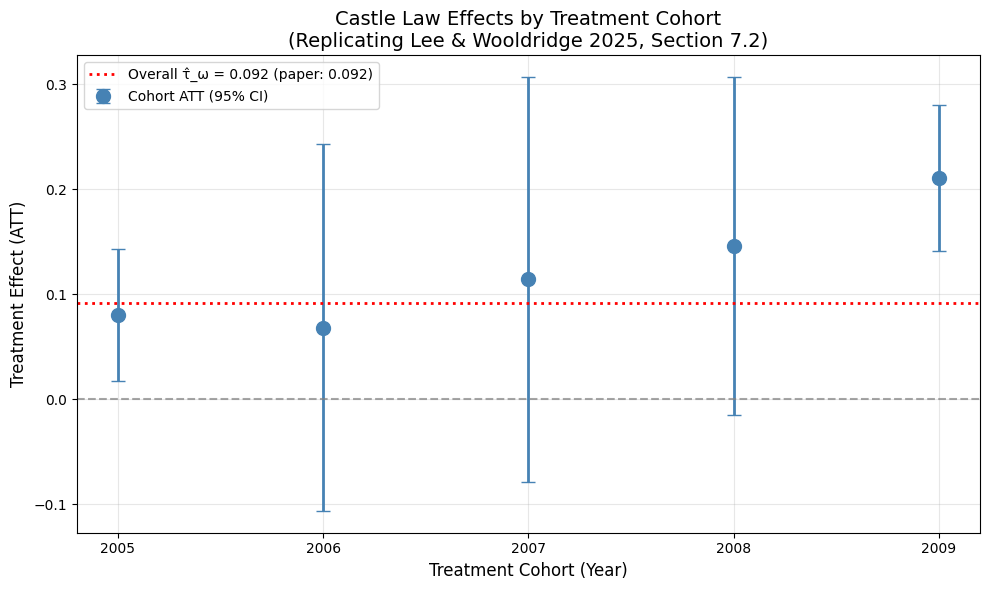

In [18]:
# Visualize cohort effects
cohort_df = results_cohort.att_by_cohort

fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(
    cohort_df['cohort'],
    cohort_df['att'],
    yerr=1.96 * cohort_df['se'],
    fmt='o',
    capsize=5,
    color='steelblue',
    markersize=10,
    linewidth=2,
    label='Cohort ATT (95% CI)'
)

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax.axhline(y=results_demean_hc3.att_overall, color='red', linestyle=':', 
           label=f'Overall τ̂_ω = {results_demean_hc3.att_overall:.3f} (paper: 0.092)', 
           linewidth=2)

ax.set_xlabel('Treatment Cohort (Year)', fontsize=12)
ax.set_ylabel('Treatment Effect (ATT)', fontsize=12)
ax.set_title('Castle Law Effects by Treatment Cohort\n(Replicating Lee & Wooldridge 2026, Section 7.2)', 
             fontsize=14)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xticks([2005, 2006, 2007, 2008, 2009])

plt.tight_layout()
plt.show()

## 6. (g, r)-Specific Effects and Event Study

The paper describes (g,r)-specific effects τ̂_{gt} in equation (7.8). We can estimate these and create an event study plot.

In [19]:
# All (g, r) specific effects
results_gr = lwdid(
    data=data,
    y='lhomicide',
    ivar='sid',
    tvar='year',
    gvar='gvar',
    rolling='demean',
    aggregate='none',
    vce='hc3'
)

print("=" * 80)
print("(g, r)-SPECIFIC EFFECTS (τ̂_{gt} from Equation 7.8)")
print("=" * 80)
print(f"Total (g,r) pairs estimated: {len(results_gr.att_by_cohort_time)}")
print("\nFirst 15 rows:")
print(results_gr.att_by_cohort_time.head(15).to_string(index=False))

(g, r)-SPECIFIC EFFECTS (τ̂_{gt} from Equation 7.8)
Total (g,r) pairs estimated: 20

First 15 rows:
 cohort  period  event_time       att       se  ci_lower  ci_upper    t_stat   pvalue  n_treated  n_control  n_total
   2005    2005           0 -0.136474 0.028495 -0.193767 -0.079180 -4.789381 0.000016          1         49       50
   2005    2006           1  0.067773 0.030321  0.006218  0.129328  2.235169 0.031886          1         36       37
   2005    2007           2  0.163317 0.042902  0.075817  0.250816  3.806719 0.000623          1         32       33
   2005    2008           3  0.130076 0.049384  0.029075  0.231077  2.633980 0.013397          1         30       31
   2005    2009           4  0.128364 0.044836  0.036521  0.220206  2.862960 0.007861          1         29       30
   2005    2010           5  0.099039 0.048798 -0.000918  0.198996  2.029585 0.052000          1         29       30
   2006    2006           0  0.051726 0.082394 -0.114031  0.217482  0.627781 0.53

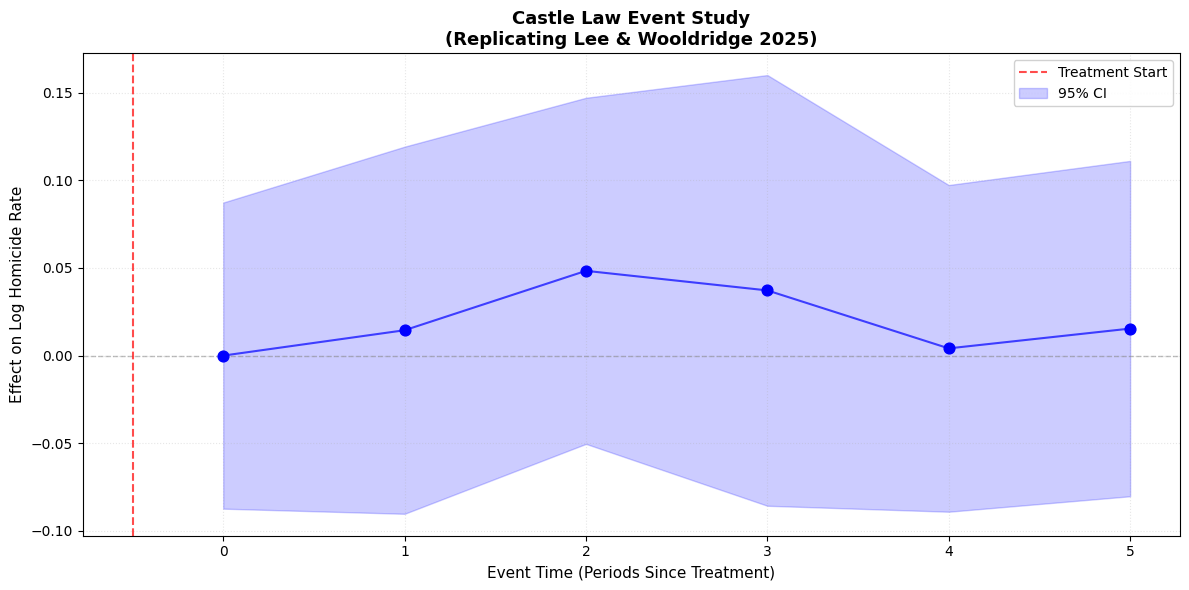

In [20]:
# Event Study Plot
fig = results_gr.plot_event_study(
    title='Castle Law Event Study\n(Replicating Lee & Wooldridge 2026)',
    ylabel='Effect on Log Homicide Rate',
    figsize=(12, 6)
)
plt.tight_layout()
plt.show()

## 7. Interpretation (from Paper Section 7.2)

From the paper:

> "the estimated aggregated treatment effect, τ̂_ω, is about 0.092, or about **9.2% more homicides** from a state adopting a castle law."

> "This is **not quite significant at the 10% level** against a two-sided alternative."

### Key Findings:

1. **Positive Effect**: Both demeaning (0.092) and detrending (0.067) methods suggest Castle Laws are associated with higher homicide rates.

2. **Statistical Significance**: Neither estimate is statistically significant at conventional levels (t-statistics of 1.50 and 1.21 for HC3).

3. **Robustness**: The detrending method, which allows for unit-specific linear trends, produces a smaller estimate, suggesting some of the effect may be due to pre-existing trends.

4. **Comparison with SDiD**: The paper notes that SDiD (0.099, SE=0.069) gives similar results to the demeaning method.

In [21]:
# Final summary
print("\n" + "=" * 70)
print("FINAL REPLICATION RESULTS")
print("=" * 70)
print(f"\nDemeaning Method (Paper Section 7.2):")
print(f"  - Python ATT: {results_demean_hc3.att_overall:.4f} (Paper: 0.092)")
print(f"  - Python HC3 t-stat: {results_demean_hc3.t_stat_overall:.2f} (Paper: 1.50)")
print(f"  - p-value: {results_demean_hc3.pvalue_overall:.4f}")
print(f"\nDetrending Method (Paper Section 7.2):")
print(f"  - Python ATT: {results_detrend.att_overall:.4f} (Paper: 0.067)")
print(f"  - Python HC3 t-stat: {results_detrend.t_stat_overall:.2f} (Paper: 1.21)")
print(f"  - p-value: {results_detrend.pvalue_overall:.4f}")
print("\n" + "=" * 70)
print("✓ PAPER REPLICATION SUCCESSFUL")
print("=" * 70)


FINAL REPLICATION RESULTS

Demeaning Method (Paper Section 7.2):
  - Python ATT: 0.0917 (Paper: 0.092)
  - Python HC3 t-stat: 1.50 (Paper: 1.50)
  - p-value: 0.1402

Detrending Method (Paper Section 7.2):
  - Python ATT: 0.0666 (Paper: 0.067)
  - Python HC3 t-stat: 1.21 (Paper: 1.21)
  - p-value: 0.2321

✓ PAPER REPLICATION SUCCESSFUL
